# Confusion matrix 만들기

In [1]:
import json
import pandas as pd
from pandas import json_normalize

## ground truth.json 불러오기
1. 파일을 읽어서 dataframe에 넣기
2. gameTime, label만 추출
3. gameTime에서 분:초를 제외한 데이터 삭제

In [2]:
with open("C:\\Users\\user\\Desktop\\Jupyter\\TASK1_Confusion_matrix\\input\\groun_truth.json", "r", encoding="utf8") as f:
    contents = f.read() # string 타입
    json_data = json.loads(contents)
df_json_data_groun_truth = json_normalize(json_data['annotations']) # json파일 -> dataframe에 넣기
df_json_data_groun_truth = df_json_data_groun_truth.loc[:, ['gameTime', 'label']] # 내가 원하는 데이터만 추출
df_json_data_groun_truth['gameTime'] = df_json_data_groun_truth.gameTime.str.split(' - ').str[1]  # 1 - , 2 - 와 같은 데이터 삭제

df_json_data_groun_truth # 출력

,gameTime,label
0,00:00,Other
1,00:14,Shots on target
2,00:15,Goal
3,00:26,Goal
4,02:49,Direct free-kick
...,...,...
338,116:36,Goal
339,116:42,Corner
340,116:46,Goal
341,116:50,Corner


## prediction.json 불러오기
1. 파일을 읽어서 dataframe에 넣기
2. gameTime, label만 추출
3. gameTime에서 분:초 가 아닌 데이터 삭제
4. 특정 threshold를 기준으로 데이터 줄이기
5. gameTime에서 Min, Sec을 추출하여 정렬하기

In [3]:
confidence_threshold = 0.3


with open("C:\\Users\\user\\Desktop\\Jupyter\\TASK1_Confusion_matrix\\input\\prediction.json", "r", encoding="utf8") as f:
    contents = f.read() # string 타입
    json_data = json.loads(contents)
df = json_normalize(json_data['predictions'])  # json파일 -> dataframe에 넣기
df = df.loc[:, ['gameTime', 'label', 'confidence', 'half']]   # 내가 원하는 데이터만 추출
df['gameTime'] = df.gameTime.str.split(' - ').str[1]  # 1 - , 2 - 와 같은 데이터 삭제
df['confidence'] = df['confidence'].astype(float)     # 내가 원하는 퍼센트 이상만 받기 위해 float형으로 변환
index_drop = df[df['confidence'] <= confidence_threshold].index         # 특정 값 이하 삭제의 index 모으기
df.drop(index_drop, inplace=True)                       # 해당 index 삭제

df['MIN'] = df.gameTime.str.split(':').str[0]  # gameTime에서 분 추출
df['MIN'] = pd.to_numeric(df['MIN'])
df['SEC'] = df.gameTime.str.split(':').str[1]  # gameTime에서 초 추출
df['SEC'] = pd.to_numeric(df['SEC'])

# predict "1 - "의 분, 초가 58분 31초에서 끊겨서 "2 - "에는 해당 숫자만큼 더하여 진행
for i in df.index :
    if df['half'][i] == "2" :
        df['MIN'][i] += 58
        df['SEC'][i] += 31


df_json_data_prediction = df.sort_values(by = ['MIN', 'SEC']) # gameTime을 기준으로 정렬
df_json_data_prediction = df_json_data_prediction.reset_index(drop=True) # 인덱스 재설정

df_json_data_prediction # 출력

C:\Users\user\AppData\Local\Temp\ipykernel_20688\2823865.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN'][i] += 58
C:\Users\user\AppData\Local\Temp\ipykernel_20688\2823865.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEC'][i] += 31


,gameTime,label,confidence,half,MIN,SEC
0,0:4,Substitution,0.448288,1,0,4
1,0:14,Corner,0.896660,1,0,14
2,0:16,Ball out of play,0.550042,1,0,16
3,0:31,Kick-off,0.757758,1,0,31
4,1:3,Substitution,0.374071,1,1,3
...,...,...,...,...,...,...
651,58:8,Substitution,0.323211,2,116,39
652,58:16,Kick-off,0.412479,2,116,47
653,58:21,Goal,0.537783,2,116,52
654,58:32,Kick-off,0.940929,2,116,63


시간 비교를 위해 df_json_data_groun_truth, df_json_data_prediction의 Game time을 지우고 MIN * 60 + Second로 Time label 추가.

In [4]:
df_json_data_groun_truth['MIN'] = df_json_data_groun_truth.gameTime.str.split(':').str[0]  # gameTime에서 분 추출
df_json_data_groun_truth['MIN'] = pd.to_numeric(df_json_data_groun_truth['MIN'])
df_json_data_groun_truth['SEC'] = df_json_data_groun_truth.gameTime.str.split(':').str[1]  # gameTime에서 초 추출
df_json_data_groun_truth['SEC'] = pd.to_numeric(df_json_data_groun_truth['SEC'])

In [5]:
df_json_data_groun_truth['Time'] = df_json_data_groun_truth['MIN']*60 + df_json_data_groun_truth['SEC']
df_json_data_groun_truth.drop(['MIN', 'SEC'], axis=1, inplace=True)

df_json_data_prediction['Time'] = df_json_data_prediction['MIN']*60 + df_json_data_prediction['SEC']
df_json_data_prediction.drop(['MIN', 'SEC', 'half', 'confidence'], axis=1, inplace=True)

df_json_data_prediction

,gameTime,label,Time
0,0:4,Substitution,4
1,0:14,Corner,14
2,0:16,Ball out of play,16
3,0:31,Kick-off,31
4,1:3,Substitution,63
...,...,...,...
651,58:8,Substitution,6999
652,58:16,Kick-off,7007
653,58:21,Goal,7012
654,58:32,Kick-off,7023


## confusion matrix
참고자료

1. https://panython.tistory.com/20

2. http://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html

In [6]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib

import matplotlib.pyplot as plt
import numpy as np

#### Counting
    인풋 :1. df_json_data_groun_truth -> game_time, label이 있는 dataframe
          2. df_json_data_prediction  -> game_time, label이 있는 dataframe
          나머지 데이터는 여기부터 필요 X
          
    아웃풋 : cmat에 숫자를 추가한 것

In [7]:
class_dict = {0 : 'Ball out of play',
              1 : 'Throw-in',
              2 : 'Foul',
              3 : 'Indirect free-kick',
              4 : 'Clearance',
              5 : 'Shots on target',
              6 : 'Shots off target',
              7 : 'Corner',
              8 : 'Substitution',
              9 : 'Kick-off',
              10 : 'Yellow card',
              11 : 'Offside',
              12 : 'Direct free-kick',
              13 : 'Goal',
              14 : 'Penalty',
              15 : 'Red card',
              16 : 'Start of game',
              17 : 'End of game',
              18 : 'Start of replay',
              19 : 'End of replay',
              20 : 'Yellow card -> red card',
              21 : 'Other'}

In [8]:
class_dict = dict(map(reversed,class_dict.items()))

In [9]:
class_dict

{'Ball out of play': 0,
 'Throw-in': 1,
 'Foul': 2,
 'Indirect free-kick': 3,
 'Clearance': 4,
 'Shots on target': 5,
 'Shots off target': 6,
 'Corner': 7,
 'Substitution': 8,
 'Kick-off': 9,
 'Yellow card': 10,
 'Offside': 11,
 'Direct free-kick': 12,
 'Goal': 13,
 'Penalty': 14,
 'Red card': 15,
 'Start of game': 16,
 'End of game': 17,
 'Start of replay': 18,
 'End of replay': 19,
 'Yellow card -> red card': 20,
 'Other': 21}

In [10]:
cmat = np.array([0]*len(class_dict)*len(class_dict)).reshape((len(class_dict), len(class_dict)))
cmat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [11]:
total_predict_lable_num = np.array([0]*len(class_dict)).reshape(len(class_dict))
total_GT_lable_num = np.array([0]*len(class_dict)).reshape(len(class_dict))
total_predict_lable_num

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
for i in df_json_data_prediction.index:
    position = class_dict.get(df_json_data_prediction["label"][i])
    total_predict_lable_num[position] += 1
#     idx = class_dict.items(df_json_data_prediction["label"][i])
# value값으로 key값 찾아서 total_predict_lable_num[label key]에 ++ 해서 저 밑에서 dataFrame에 저장

In [13]:
for i in df_json_data_groun_truth.index:
    position = class_dict.get(df_json_data_groun_truth["label"][i])
    total_GT_lable_num[position] += 1

In [14]:
total_predict_lable_num

array([111,  25,   4,   0,  60,  36,  12,  39,  89, 243,   1,   0,   1,
        35,   0,   0,   0,   0,   0,   0,   0,   0])

In [15]:
total_GT_lable_num

array([77, 42, 22, 20, 15,  1,  0, 12,  9,  4,  3,  6,  2, 38,  0,  0,  2,
        2, 44, 43,  0,  1])

### confusion matrix에 conunting하기

In [16]:
time_interval_threshold = 5

for i in df_json_data_groun_truth.index:
    index = 0
    matching = False
    
    for j in df_json_data_prediction.index:
        temp = df_json_data_groun_truth["Time"][i] - df_json_data_prediction["Time"][j]
        if temp > time_interval_threshold :
            continue
            
        elif temp < -1 * time_interval_threshold :
            break
            
        else : # 시간 차가 양 쪽의 threshold 안에 있다면 == margin 안에 있을 때
            if df_json_data_groun_truth["label"][i] == df_json_data_prediction["label"][j] :
                matching = True
                index = j
                break
    
    if not matching :
        min_time_diff = abs(df_json_data_groun_truth["Time"][i] - df_json_data_prediction["Time"][0])
        for j in df_json_data_prediction.index:
            temp = abs(df_json_data_groun_truth["Time"][i] - df_json_data_prediction["Time"][j])
            if min_time_diff >= temp:
                min_time_diff = temp
                index = j
                matching = True


    x = class_dict.get(df_json_data_groun_truth["label"][i])
    y = class_dict.get(df_json_data_prediction["label"][index])
    if matching :
        print("GT time :", df_json_data_groun_truth["gameTime"][i], "GT label ", df_json_data_groun_truth["label"][i])
        print("pred time : ",df_json_data_prediction["gameTime"][index], "pred label : ",df_json_data_prediction["label"][index])
        print("==================================")
        cmat[x,y] += 1

GT time : 00:00 GT label  Other
pred time :  0:4 pred label :  Substitution
GT time : 00:14 GT label  Shots on target
pred time :  0:14 pred label :  Corner
GT time : 00:15 GT label  Goal
pred time :  0:16 pred label :  Ball out of play
GT time : 00:26 GT label  Goal
pred time :  0:31 pred label :  Kick-off
GT time : 02:49 GT label  Direct free-kick
pred time :  2:53 pred label :  Corner
GT time : 02:50 GT label  Goal
pred time :  2:53 pred label :  Corner
GT time : 02:55 GT label  Goal
pred time :  2:53 pred label :  Corner
GT time : 02:57 GT label  Goal
pred time :  2:53 pred label :  Corner
GT time : 03:00 GT label  Goal
pred time :  3:2 pred label :  Kick-off
GT time : 03:04 GT label  Goal
pred time :  3:2 pred label :  Kick-off
GT time : 03:07 GT label  Goal
pred time :  3:8 pred label :  Substitution
GT time : 03:44 GT label  Goal
pred time :  3:52 pred label :  Substitution
GT time : 03:47 GT label  Goal
pred time :  3:52 pred label :  Substitution
GT time : 03:51 GT label  Goal

GT time : 31:42 GT label  Ball out of play
pred time :  31:41 pred label :  Ball out of play
GT time : 31:57 GT label  Throw-in
pred time :  32:1 pred label :  Throw-in
GT time : 32:42 GT label  Foul
pred time :  32:42 pred label :  Kick-off
GT time : 32:44 GT label  Ball out of play
pred time :  32:41 pred label :  Ball out of play
GT time : 32:47 GT label  Offside
pred time :  32:44 pred label :  Clearance
GT time : 32:48 GT label  Start of replay
pred time :  32:44 pred label :  Clearance
GT time : 32:54 GT label  End of replay
pred time :  32:54 pred label :  Substitution
GT time : 33:16 GT label  Indirect free-kick
pred time :  33:20 pred label :  Kick-off
GT time : 33:25 GT label  Ball out of play
pred time :  33:27 pred label :  Ball out of play
GT time : 33:36 GT label  Throw-in
pred time :  33:35 pred label :  Throw-in
GT time : 34:23 GT label  Foul
pred time :  34:30 pred label :  Ball out of play
GT time : 34:34 GT label  Start of replay
pred time :  34:34 pred label :  Kick

GT time : 53:43 GT label  Foul
pred time :  53:51 pred label :  Kick-off
GT time : 53:46 GT label  Offside
pred time :  53:51 pred label :  Kick-off
GT time : 53:47 GT label  Indirect free-kick
pred time :  53:51 pred label :  Kick-off
GT time : 54:21 GT label  Ball out of play
pred time :  54:26 pred label :  Ball out of play
GT time : 54:32 GT label  Start of replay
pred time :  54:26 pred label :  Corner
GT time : 54:46 GT label  End of replay
pred time :  54:40 pred label :  Kick-off
GT time : 54:57 GT label  Corner
pred time :  54:55 pred label :  Corner
GT time : 54:59 GT label  Goal
pred time :  55:1 pred label :  Goal
GT time : 55:19 GT label  Start of replay
pred time :  55:27 pred label :  Kick-off
GT time : 55:55 GT label  End of replay
pred time :  56:1 pred label :  Clearance
GT time : 55:58 GT label  Kick-off
pred time :  56:1 pred label :  Clearance
GT time : 56:20 GT label  Ball out of play
pred time :  56:24 pred label :  Shots on target
GT time : 56:59 GT label  Corne

GT time : 78:17 GT label  Start of replay
pred time :  19:53 pred label :  Kick-off
GT time : 78:41 GT label  End of replay
pred time :  20:11 pred label :  Kick-off
GT time : 78:46 GT label  Ball out of play
pred time :  20:13 pred label :  Clearance
GT time : 78:50 GT label  Throw-in
pred time :  20:13 pred label :  Clearance
GT time : 80:37 GT label  Ball out of play
pred time :  22:0 pred label :  Ball out of play
GT time : 80:42 GT label  Start of replay
pred time :  22:16 pred label :  Kick-off
GT time : 80:53 GT label  End of replay
pred time :  22:21 pred label :  Corner
GT time : 81:08 GT label  Corner
pred time :  22:37 pred label :  Corner
GT time : 81:10 GT label  Ball out of play
pred time :  22:39 pred label :  Ball out of play
GT time : 81:42 GT label  Substitution
pred time :  23:10 pred label :  Substitution
GT time : 81:51 GT label  Substitution
pred time :  23:22 pred label :  Ball out of play
GT time : 82:00 GT label  Clearance
pred time :  23:23 pred label :  Clear

GT time : 116:46 GT label  Goal
pred time :  58:16 pred label :  Kick-off
GT time : 116:50 GT label  Corner
pred time :  58:21 pred label :  Goal
GT time : 116:52 GT label  Goal
pred time :  58:21 pred label :  Goal


In [17]:
print(np.sum(cmat))

343


In [18]:
print(cmat)

[[48  2  2  0  4  6  1  1  0 12  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 4 14  0  0  6  0  0  2  2 13  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 7  1  0  0  0  1  0  0  1 10  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  0  2  1 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  9  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  9  1  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  0  0  1  3  1  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  3  9 19  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


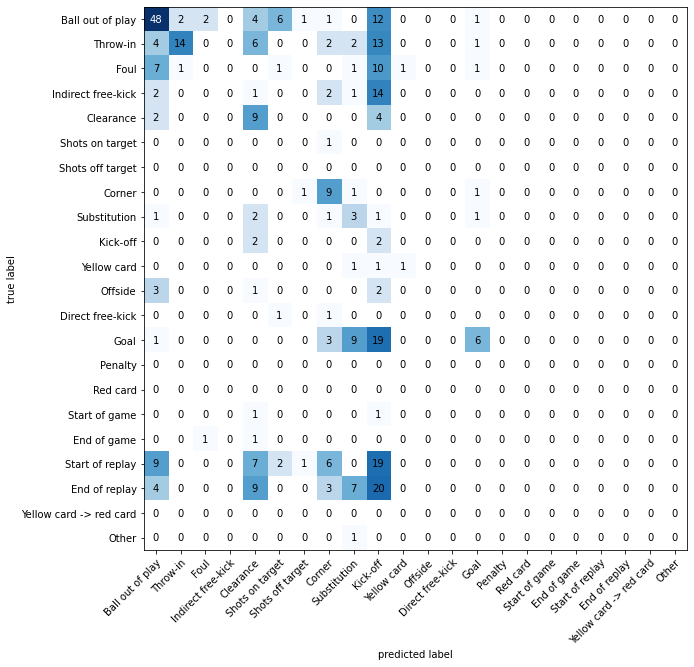

In [19]:
fig, ax = plot_confusion_matrix(
    conf_mat=cmat, figsize = (10, 10),
    class_names=class_dict.keys(),
    norm_colormap=matplotlib.colors.LogNorm()  
)

## Precision, recall 구하기

## label 별 FP, FN , ... 구하기

In [20]:
sum_total = np.sum(cmat)
class_dict = dict(map(reversed,class_dict.items()))


In [21]:
columns = ["label name","TP", "FN", "FP", "TN"]
lable_score = pd.DataFrame(columns=columns)

In [22]:
sum_column = np.array(cmat.sum(axis=0))

for idx in range(0, len(class_dict)):
    TP = 0
    FN = 0
    for idx_x, value_x in enumerate(cmat[idx]):
        if idx_x == idx :
            TP = value_x
        else:
            FN += value_x

    FP = sum_column[idx] - TP
    TN = sum_total - TP - FN - FP
    lable_score.loc[idx] = [class_dict.get(idx), TP, FN, FP, TN]


# dataFrame 완성

## precision, recall 계산

In [23]:
lable_score["Precision"] = lable_score["TP"] / total_predict_lable_num
lable_score["Recall"] = lable_score["TP"] / total_GT_lable_num

In [24]:
lable_score

,label name,TP,FN,FP,TN,Precision,Recall
0,Ball out of play,48,29,33,233,0.432432,0.623377
1,Throw-in,14,28,3,298,0.560000,0.333333
2,Foul,0,22,3,318,0.000000,0.000000
3,Indirect free-kick,0,20,0,323,NaN,0.000000
4,Clearance,9,6,34,294,0.150000,0.600000
5,Shots on target,0,1,10,332,0.000000,0.000000
6,Shots off target,0,0,3,340,0.000000,NaN
7,Corner,9,3,20,311,0.230769,0.750000
8,Substitution,3,6,23,311,0.033708,0.333333
9,Kick-off,2,2,116,223,0.008230,0.500000
